In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *

# Hyperparam schedule

> Callback and helper functions to schedule any hyper-parameter

## Synthetic data

We'll use the following for testing purposes (a basic linear regression problem):

In [ ]:
from torch.utils.data import TensorDataset

def synth_data(a=2, b=3, bs=16, n_trn=10, n_val=2):
    x_trn = torch.randn(bs*n_trn)
    y_trn = a*x_trn + b + 0.1*torch.randn(bs*n_trn)
    x_val = torch.randn(bs*n_val)
    y_val = a*x_val + b + 0.1*torch.randn(bs*n_val)
    train_ds = TensorDataset(x_trn, y_trn)
    valid_ds = TensorDataset(x_val, y_val)
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True)
    valid_dl = TfmdDL(valid_ds, bs=bs)
    return DataBunch(train_dl, valid_dl)

In [ ]:
class RegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x * self.a + self.b

In [ ]:
def synth_learner(n_trn=10, n_val=2, **kwargs):
    return Learner(RegModel(), synth_data(n_trn=n_trn,n_val=n_val), MSELossFlat(), opt_func=partial(SGD, mom=0.9), **kwargs)

## Annealing

In [ ]:
#export
def annealer(f):
    "Decorator to make `f` return itself partially applied."
    def _inner(start, end): return partial(f, start, end)
    return _inner

This is the decorator we will use for all of our scheduling functions, as it transforms a function taking `(start, end, pos)` to something taking `(start, end)` and return a function depending of `pos`.

In [ ]:
#export
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no (start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

sched_lin.__doc__ = "Linear schedule function from `start` to `end`"
sched_cos.__doc__ = "Cosine schedule function from `start` to `end`"
sched_no .__doc__ = "Constant schedule function with `start` value"
sched_exp.__doc__ = "Exponential schedule function from `start` to `end`"

In [ ]:
show_doc(sched_lin, name='sched_lin')

<h4 id="<code>sched_lin</code>" class="doc_header"><code>sched_lin</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_lin</code>(**`start`**, **`end`**)

Linear schedule function from `start` to `end`

In [ ]:
sched = sched_lin(0, 2)
test_eq(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.5, 1., 1.5, 2.])

In [ ]:
show_doc(sched_cos, name='sched_cos')

<h4 id="<code>sched_cos</code>" class="doc_header"><code>sched_cos</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_cos</code>(**`start`**, **`end`**)

Cosine schedule function from `start` to `end`

In [ ]:
sched = sched_cos(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.29289, 1., 1.70711, 2.])

In [ ]:
show_doc(sched_no, name='sched_no')

<h4 id="<code>sched_no</code>" class="doc_header"><code>sched_no</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_no</code>(**`start`**, **`end`**)

Constant schedule function with `start` value

In [ ]:
sched = sched_no(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0., 0., 0., 0.])

In [ ]:
show_doc(sched_exp, name='sched_exp')

<h4 id="<code>sched_exp</code>" class="doc_header"><code>sched_exp</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_exp</code>(**`start`**, **`end`**)

Exponential schedule function from `start` to `end`

In [ ]:
sched = sched_exp(1, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [1., 1.18921, 1.41421, 1.68179, 2.])

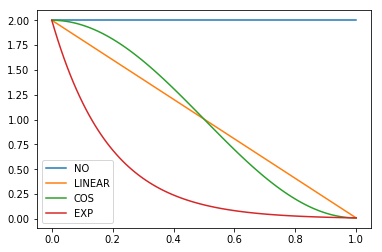

In [ ]:
annealings = "NO LINEAR COS EXP".split()

p = torch.linspace(0.,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(p, [f(o) for o in p], label=t)
plt.legend();

In [ ]:
def sched_poly(start, end, power): 
    "Polynomial schedule (of `power`) function from `start` to `end`"
    def _inner(pos): return start + (end - start) * pos ** power
    return _inner

In [ ]:
sched = sched_poly(0, 2, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.125, 0.5, 1.125, 2.])

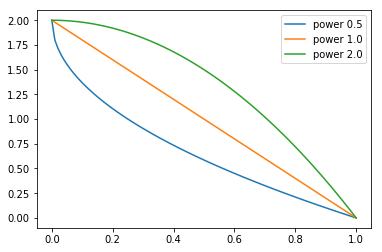

In [ ]:
p = torch.linspace(0.,1,100)

pows = [0.5,1.,2.]
for e in pows:
    f = sched_poly(2, 0, e)
    plt.plot(p, [f(o) for o in p], label=f'power {e}')
plt.legend();

In [ ]:
#export
def combine_scheds(pcts, scheds):
    "Combine `scheds` according to `pcts` in one function"
    assert sum(pcts) == 1.
    pcts = tensor([0] + L(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        if pos == 1.: return scheds[-1](1.)
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

`pcts` must be a list of positive numbers that add up to 1 and is the same length as `scheds`. The generated function will use `scheds[0]` from 0 to `pcts[0]` then `scheds[1]` from `pcts[0]` to `pcts[0]+pcts[1]` and so forth.

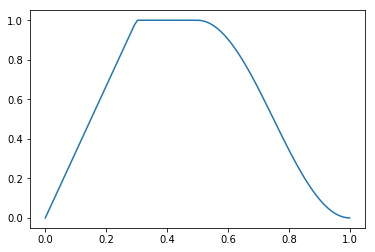

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3,0.2,0.5], [sched_lin(0.,1.), sched_no(1.,1.), sched_cos(1., 0.)])
plt.plot(p, [f(o) for o in p]);

In [ ]:
#hide
test_close([f(0.), f(0.15), f(0.3), f(0.4), f(0.5), f(0.7), f(1.)],
           [0., 0.5, 1., 1., 1., 0.65451, 0.])

In [ ]:
def combined_cos(pct, start, middle, end):
    "Return a combined scheduler with cosine annealing from `start` to `middle` then `middle` to `end`"
    if is_listy(start): 
        return [combine_scheds([pct,1-pct], [sched_cos(s, m), sched_cos(m, e)]) 
                for s,m,e in zip(start,middle,end)] 
    return combine_scheds([pct,1-pct], [sched_cos(start, middle), sched_cos(middle, end)])

This is a useful helper function for the 1cycle policy. `pct` is used for the `start` to `middle` part, `1-pct` for the `middle` to `end`. Handles floats or collection of floats.

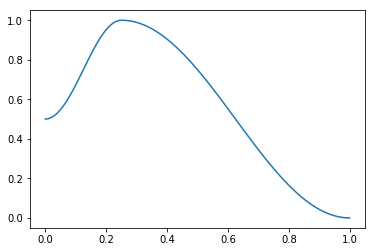

In [ ]:
p = torch.linspace(0.,1,100)
f = combined_cos(0.25,0.5,1.,0.)
plt.plot(p, [f(o) for o in p]);

In [ ]:
#hide
test_close([f(0.), f(0.1), f(0.25), f(0.5), f(1.)], [0.5, 0.67275, 1., 0.75, 0.])
fs = combined_cos(0.25, [0.25,0.5], [0.5,1.], [0.,0.])
test_eq(len(fs), 2)
f,g = fs
test_close([f(0.), f(0.1), f(0.25), f(0.5), f(1.)], [0.25, 0.33638, 0.5, 0.375, 0.])
test_close([g(0.), g(0.1), g(0.25), g(0.5), g(1.)], [0.5, 0.67275, 1., 0.75, 0.])

## ParamScheduler -

In [ ]:
@docs
class ParamScheduler(Callback):
    "Schedule hyper-parameters according to `scheds`"
    order=1
    def __init__(self, scheds): self.scheds = scheds
        
    def begin_fit(self): self.hps = {p:[] for p in self.scheds.keys()}

    def begin_batch(self):
        if not self.training: return
        for pname,fs in self.scheds.items():
            fs = L(fs)
            if len(fs)==1: fs = fs*len(self.opt.param_groups)
            for f,h in zip(fs,self.opt.hypers): h[pname] = f(self.pct_train)
    
    def after_batch(self):
        for p in self.scheds.keys(): self.hps[p].append(self.opt.hypers[-1][p])
    
    def after_fit(self):
        if hasattr(self.learn, 'recorder'): self.recorder.hps = self.hps
            
    _docs = {"begin_fit": "Initiliaze container for hyper-parameters",
             "begin_batch": "Set the proper hyper-parameters in the optimizer",
             "after_batch": "Record hyper-parameters of this batch",
             "after_fit": "Save the hyper-parameters in the recorder if there is one"}

`scheds` is a dictionary with one key for each hyper-parameter you want to schedule, with either a scheduler or a list of schedulers as values (in the second case, the list must have the same length as the the number of parameters groups of the optimizer).

In [ ]:
def _learner_fit_one_cycle(self, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, 
                           moms=(0.95,0.85,0.95), cbs=None, reset_opt=False):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    lr_max = lr_max or self.lr
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div), 
              'mom': combined_cos(pct_start, *moms)}
    self.fit(n_epoch, cbs=[ParamScheduler(scheds)]+L(cbs), reset_opt=reset_opt)
    
Learner.fit_one_cycle = _learner_fit_one_cycle

In [ ]:
show_doc(Learner.fit_one_cycle, name='Learner.fit_one_cycle')

<h4 id="<code>Learner.fit_one_cycle</code>" class="doc_header"><code>Learner.fit_one_cycle</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L1" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fit_one_cycle</code>(**`n_epoch`**, **`lr_max`**=*`None`*, **`div`**=*`25.0`*, **`div_final`**=*`100000.0`*, **`pct_start`**=*`0.25`*, **`moms`**=*`(0.95, 0.85, 0.95)`*, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fit `self.model` for `n_epoch` using the 1cycle policy.

This schedules the learning rate with a cosine annealing from `lr_max/div` to `lr_max` then `lr_max/div_final` (pass an array to `lr_max` if you want to use differential learning rates) and the momentum with cosine annealing according to the values in `moms`. The first phase takes `pct_start` of the training. You can optionally pass additional `cbs` and `reset_opt`.

In [ ]:
learn = synth_learner()
learn.fit_one_cycle(2)

[tensor(9.1036), tensor(2.8370), '00:00']
[tensor(1.2163), tensor(0.5332), '00:00']


In [ ]:
learn.recorder.hps

{'lr': [0.0004000000000000181,
  0.0013167182296787102,
  0.0037167176433466377,
  0.006683281957562158,
  0.009083281691836066,
  0.009999999999999983,
  0.009895108564951708,
  0.009585018344605952,
  0.00908328177032129,
  0.008411827139209122,
  0.008411827139209122,
  0.008411827139209122,
  0.0075999992511856535,
  0.006683282356653363,
  0.005701736277191047,
  0.004698264140139528,
  0.003716719130835662,
  0.0027999996255928554,
  0.0019881729600208092,
  0.0013167183081639333,
  0.0008149821169934398,
  0.0005048915074231195,
  0.0005048915074231195,
  0.0005048915074231195],
 'mom': [0.9499999999999997,
  0.9404508517741801,
  0.9154508578818058,
  0.8845491462753942,
  0.8595491490433743,
  0.8500000000000002,
  0.8510926191150864,
  0.8543227255770213,
  0.8595491482258198,
  0.866543467299905,
  0.866543467299905,
  0.866543467299905,
  0.8750000078001494,
  0.8845491421181941,
  0.8947735804459266,
  0.9052264152068799,
  0.9154508423871285,
  0.9250000039000744,
  0.933

In [ ]:
def plot(self):
    _, axs = plt.subplots(1, len(self.hps))
    for p,ax in zip(self.hps.keys(), axs):
        ax.plot(self.hps[p])
        ax.set_ylabel(p)

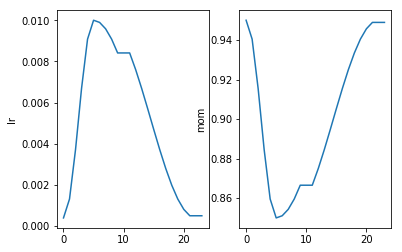

In [ ]:
plot(learn.recorder)

In [ ]:
learn.param_scheduler.plot()

AttributeError: 'NoneType' object has no attribute 'plot'